In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l2_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l2_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1523
0
26 28 (1, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2794 - total_loss: 0.2794 - reg_loss: 0.2794 - val_loss: 0.2607 - val_total_loss: 0.2607 - val_reg_loss: 0.2607
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940589 -0.011479  0.234826    7  2017-04-16
472     2.507290  2.544564 -0.037274  0.231333    1  2017-04-17
473     2.661330  2.669920 -0.008590  0.252063    2  2017-04-18
474     2.754815  2.758416 -0.003601  0.206069    3  2017-04-19
475     2.713762  2.720185 -0.006423  0.237624    4  2017-04-20
476     2.999000  2.984969  0.014031  0.153128    5  2017-04-21
477     3.075529  3.097691 -0.022162  0.187004    6  2017-04-22

0.214578080943
best_epochs [6, 3, 9, 7, 4]
(829, 1) 2.68976125078 

2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1523
0
26 28 (2, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1520/1523 [============================>.] - ETA: 0s - loss: 3.6093 - total_loss: 3.6093 - reg_loss: 3.6093Epoch 00001: saving model to testlstm_l2_3/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1523/1523 [=============================

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.929224 -0.000114  0.285747    6  2017-04-15
471     2.507290  2.605316 -0.098025  0.413160    7  2017-04-16
472     2.661330  2.698267 -0.036937  0.341418    1  2017-04-17
473     2.754815  2.759455 -0.004640  0.250819    2  2017-04-18
474     2.713762  2.752252 -0.038490  0.289557    3  2017-04-19
475     2.999000  2.984557  0.014443  0.198671    4  2017-04-20
476     3.075529  3.055225  0.020304  0.224653    5  2017-04-21

0.286289276158
best_epochs [7, 4, 8, 5, 9]
(829, 1) 2.51783947482 

3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1523
0
26 28 (3, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2820 - total_loss: 0.2820 - reg_loss: 0.2820 - val_loss: 0.2614 - val_total_loss: 0.2614 - val_reg_loss: 0.2614
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.935386 -0.006276  0.258740    5  2017-04-14
470     2.507290  2.574666 -0.067376  0.310729    6  2017-04-15
471     2.661330  2.726431 -0.065101  0.416914    7  2017-04-16
472     2.754815  2.801987 -0.047173  0.349183    1  2017-04-17
473     2.713762  2.746818 -0.033056  0.316632    2  2017-04-18
474     2.999000  2.990688  0.008312  0.194113    3  2017-04-19
475     3.075529  3.072178  0.003351  0.259206    4  2017-04-20

0.300788288963
best_epochs [6, 5, 7, 10, 8]
(829, 1) 2.63366414478 

4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1523
0
26 28 (4, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2947 - total_loss: 0.2947 - reg_loss: 0.2947 - val_loss: 0.2607 - val_total_loss: 0.2607 - val_reg_loss: 0.2607
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/step

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.903130  0.025980  0.321518    4  2017-04-13
469     2.507290  2.528003 -0.020713  0.262856    5  2017-04-14
470     2.661330  2.662644 -0.001314  0.293887    6  2017-04-15
471     2.754815  2.713409  0.041405  0.374611    7  2017-04-16
472     2.713762  2.775101 -0.061340  0.350211    1  2017-04-17
473     2.999000  2.999691 -0.000692  0.216301    2  2017-04-18
474     3.075529  3.034770  0.040760  0.268857    3  2017-04-19

0.298320083523
best_epochs [6, 5, 8, 7, 9]
(829, 1) 2.72235747879 

5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1523
0
26 28 (5, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.2838 - total_loss: 0.2838 - reg_loss: 0.2838 - val_loss: 0.2636 - val_total_loss: 0.2636 - val_reg_loss: 0.2636
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.901657  0.027453  0.356028    3  2017-04-12
468     2.507290  2.510656 -0.003365  0.289088    4  2017-04-13
469     2.661330  2.666719 -0.005389  0.285815    5  2017-04-14
470     2.754815  2.761528 -0.006714  0.260191    6  2017-04-15
471     2.713762  2.706816  0.006945  0.403057    7  2017-04-16
472     2.999000  2.974454  0.024545  0.288854    1  2017-04-17
473     3.075529  3.051166  0.024363  0.277113    2  2017-04-18

0.308592128971
best_epochs [7, 3, 5, 10, 8]
(829, 1) 2.74641272546 

6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 15.1334
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1523
0
26 28 (6, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2867 - total_loss: 0.2867 - reg_loss: 0.2867 - val_loss: 0.2659 - val_total_loss: 0.2659 - val_reg_loss: 0.2659
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/step

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.901402  0.027708  0.344296    2  2017-04-11
467     2.507290  2.568523 -0.061232  0.319570    3  2017-04-12
468     2.661330  2.672882 -0.011552  0.309524    4  2017-04-13
469     2.754815  2.756011 -0.001196  0.234971    5  2017-04-14
470     2.713762  2.714063 -0.000301  0.285373    6  2017-04-15
471     2.999000  2.889056  0.109944  0.340358    7  2017-04-16
472     3.075529  3.034061  0.041468  0.347624    1  2017-04-17

0.311673797698
best_epochs [7, 9, 4, 6, 3]
(829, 1) 3.00615502499 

7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 16.3101
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1523
0
26 28 (7, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1520/1523 [============================>.] - ETA: 0s - loss: 8.5362 - total_loss: 8.5362 - reg_loss: 8.5362Epoch 00001: saving model to testlstm_l2_3/model_adam.001.h5
epoch 0: Invalid loss, terminating training
1523/1523 [===========================

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.917978  0.011132  0.371771    1  2017-04-10
466     2.507290  2.574338 -0.067047  0.323767    2  2017-04-11
467     2.661330  2.684257 -0.022927  0.328912    3  2017-04-12
468     2.754815  2.762818 -0.008004  0.264155    4  2017-04-13
469     2.713762  2.743142 -0.029381  0.276476    5  2017-04-14
470     2.999000  3.011314 -0.012315  0.204285    6  2017-04-15
471     3.075529  3.105097 -0.029568  0.327402    7  2017-04-16

0.299538142795
best_epochs [2, 5, 7, 3, 6]
(829, 1) 2.99061395705 

8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 17.5743
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1523
0
26 28 (8, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 25s 16ms/step - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800 - val_loss: 0.2577 - val_total_loss: 0.2577 - val_reg_loss: 0.2577
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.987914 -0.058804  0.357566    7  2017-04-09
465     2.507290  2.587771 -0.080480  0.329954    1  2017-04-10
466     2.661330  2.651665  0.009665  0.307367    2  2017-04-11
467     2.754815  2.764895 -0.010080  0.286603    3  2017-04-12
468     2.713762  2.732179 -0.018417  0.289814    4  2017-04-13
469     2.999000  2.957476  0.041524  0.174880    5  2017-04-14
470     3.075529  3.084159 -0.008630  0.228669    6  2017-04-15

0.282121971091
best_epochs [5, 4, 3, 7, 8]
(829, 1) 2.74703717589 

9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 18.8065
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1523
0
26 28 (9, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 25s 16ms/step - loss: 0.2873 - total_loss: 0.2873 - reg_loss: 0.2873 - val_loss: 0.2631 - val_total_loss: 0.2631 - val_reg_loss: 0.2631
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.924829  0.004281  0.290489    6  2017-04-08
464     2.507290  2.662995 -0.155704  0.466452    7  2017-04-09
465     2.661330  2.751692 -0.090362  0.404178    1  2017-04-10
466     2.754815  2.767073 -0.012258  0.284247    2  2017-04-11
467     2.713762  2.760020 -0.046258  0.328839    3  2017-04-12
468     2.999000  3.007749 -0.008749  0.208604    4  2017-04-13
469     3.075529  3.099267 -0.023738  0.228572    5  2017-04-14

0.315911755198
best_epochs [5, 7, 4, 6, 1]
(829, 1) 2.55903897436 

10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 19.9265
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1523
0
26 28 (10, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2950 - total_loss: 0.2950 - reg_loss: 0.2950 - val_loss: 0.2741 - val_total_loss: 0.2741 - val_reg_loss: 0.2741
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.938304 -0.009194  0.280653    5  2017-04-07
463     2.507290  2.543902 -0.036612  0.297801    6  2017-04-08
464     2.661330  2.698031 -0.036702  0.410962    7  2017-04-09
465     2.754815  2.799016 -0.044201  0.340771    1  2017-04-10
466     2.713762  2.763692 -0.049931  0.306128    2  2017-04-11
467     2.999000  2.987698  0.011302  0.211825    3  2017-04-12
468     3.075529  3.076335 -0.000805  0.257846    4  2017-04-13

0.30085537408
best_epochs [7, 3, 6, 5, 4]
(829, 1) 2.65310422666 

11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 21.0577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1523
0
26 28 (11, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 25s 16ms/step - loss: 0.2944 - total_loss: 0.2944 - reg_loss: 0.2944 - val_loss: 0.2718 - val_total_loss: 0.2718 - val_reg_loss: 0.2718
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.892851  0.036259  0.320971    4  2017-04-06
462     2.507290  2.557064 -0.049774  0.272233    5  2017-04-07
463     2.661330  2.696920 -0.035590  0.314060    6  2017-04-08
464     2.754815  2.755447 -0.000632  0.374813    7  2017-04-09
465     2.713762  2.791389 -0.077627  0.365539    1  2017-04-10
466     2.999000  2.983815  0.015185  0.226613    2  2017-04-11
467     3.075529  3.034916  0.040613  0.270761    3  2017-04-12

0.306427294767
best_epochs [7, 6, 5, 3, 9]
(829, 1) 3.05003178436 

12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 22.1151
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1523
0
26 28 (12, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2964 - total_loss: 0.2964 - reg_loss: 0.2964 - val_loss: 0.2713 - val_total_loss: 0.2713 - val_reg_loss: 0.2713
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.856733  0.072377  0.332152    3  2017-04-05
461     2.507290  2.537481 -0.030190  0.291494    4  2017-04-06
462     2.661330  2.652421  0.008909  0.313505    5  2017-04-07
463     2.754815  2.727363  0.027452  0.264941    6  2017-04-08
464     2.713762  2.701668  0.012093  0.389704    7  2017-04-09
465     2.999000  2.968627  0.030373  0.262531    1  2017-04-10
466     3.075529  3.044153  0.031377  0.269936    2  2017-04-11

0.303466219525
best_epochs [4, 7, 2, 3, 6]
(829, 1) 2.968519249 

13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 23.1552
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1523
0
26 28 (13, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 25s 16ms/step - loss: 0.2978 - total_loss: 0.2978 - reg_loss: 0.2978 - val_loss: 0.2726 - val_total_loss: 0.2726 - val_reg_loss: 0.2726
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/ste

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.908104  0.021006  0.351608    2  2017-04-04
460     2.507290  2.576393 -0.069103  0.308834    3  2017-04-05
461     2.661330  2.706899 -0.045569  0.317318    4  2017-04-06
462     2.754815  2.773508 -0.018693  0.268499    5  2017-04-07
463     2.713762  2.746128 -0.032366  0.291384    6  2017-04-08
464     2.999000  2.954290  0.044710  0.318243    7  2017-04-09
465     3.075529  3.051242  0.024288  0.309155    1  2017-04-10

0.309291705921
best_epochs [5, 3, 4, 7, 9]
(829, 1) 3.13421582095 

14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 24.2264
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1523
0
26 28 (14, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2936 - total_loss: 0.2936 - reg_loss: 0.2936 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.929359 -0.000249  0.389083    1  2017-04-03
459     2.507290  2.542821 -0.035531  0.285673    2  2017-04-04
460     2.661330  2.699591 -0.038261  0.332475    3  2017-04-05
461     2.754815  2.764481 -0.009666  0.274857    4  2017-04-06
462     2.713762  2.753019 -0.039258  0.289148    5  2017-04-07
463     2.999000  2.985626  0.013374  0.195218    6  2017-04-08
464     3.075529  3.100675 -0.025146  0.318530    7  2017-04-09

0.297854964137
best_epochs [4, 7, 5, 6, 3]
(829, 1) 3.08800931189 

15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 25.3577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1523
0
26 28 (15, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2883 - total_loss: 0.2883 - reg_loss: 0.2883 - val_loss: 0.2681 - val_total_loss: 0.2681 - val_reg_loss: 0.2681
Epoch 2/100
1523/1523 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.973871 -0.044761  0.396441    7  2017-04-02
458     2.507290  2.611671 -0.104380  0.373718    1  2017-04-03
459     2.661330  2.716222 -0.054893  0.331389    2  2017-04-04
460     2.754815  2.788419 -0.033604  0.296951    3  2017-04-05
461     2.713762  2.740699 -0.026937  0.314996    4  2017-04-06
462     2.999000  2.999811 -0.000811  0.182217    5  2017-04-07
463     3.075529  3.077352 -0.001823  0.228473    6  2017-04-08

0.303454976202
best_epochs [4, 2, 6, 7, 5]
(829, 1) 2.74599235588 

16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 26.4659
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1523
0
26 28 (16, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2957 - total_loss: 0.2957 - reg_loss: 0.2957 - val_loss: 0.2740 - val_total_loss: 0.2740 - val_reg_loss: 0.2740
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.908693  0.020417  0.298938    6  2017-04-01
457     2.507290  2.667427 -0.160137  0.484337    7  2017-04-02
458     2.661330  2.774018 -0.112688  0.407970    1  2017-04-03
459     2.754815  2.801801 -0.046986  0.288125    2  2017-04-04
460     2.713762  2.784091 -0.070330  0.335716    3  2017-04-05
461     2.999000  3.024459 -0.025459  0.219773    4  2017-04-06
462     3.075529  3.045218  0.030311  0.228190    5  2017-04-07

0.323292941536
best_epochs [5, 4, 2, 8, 6]
(829, 1) 2.56371340627 

17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 27.6058
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1523
0
26 28 (17, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2980 - total_loss: 0.2980 - reg_loss: 0.2980 - val_loss: 0.2770 - val_total_loss: 0.2770 - val_reg_loss: 0.2770
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.907590  0.021520  0.292671    5  2017-03-31
456     2.507290  2.538399 -0.031109  0.289795    6  2017-04-01
457     2.661330  2.691604 -0.030274  0.411778    7  2017-04-02
458     2.754815  2.778205 -0.023390  0.352750    1  2017-04-03
459     2.713762  2.753859 -0.040097  0.325717    2  2017-04-04
460     2.999000  2.997325  0.001674  0.219117    3  2017-04-05
461     3.075529  3.040049  0.035480  0.256058    4  2017-04-06

0.306840860839
best_epochs [4, 3, 8, 7, 5]
(829, 1) 2.64740221471 

18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 28.7513
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1523
0
26 28 (18, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2989 - total_loss: 0.2989 - reg_loss: 0.2989 - val_loss: 0.2804 - val_total_loss: 0.2804 - val_reg_loss: 0.2804
Epoch 2/100
1523/1523 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.951539 -0.022429  0.329094    4  2017-03-30
455     2.507290  2.541483 -0.034193  0.265267    5  2017-03-31
456     2.661330  2.705843 -0.044513  0.319858    6  2017-04-01
457     2.754815  2.741056  0.013759  0.360788    7  2017-04-02
458     2.713762  2.792165 -0.078403  0.356952    1  2017-04-03
459     2.999000  3.016946 -0.017946  0.227966    2  2017-04-04
460     3.075529  3.086558 -0.011029  0.250575    3  2017-04-05

0.301499958522
best_epochs [7, 3, 5, 2, 6]
(829, 1) 2.7211604239 

19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 29.7986
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1523
0
26 28 (19, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2973 - total_loss: 0.2973 - reg_loss: 0.2973 - val_loss: 0.2832 - val_total_loss: 0.2832 - val_reg_loss: 0.2832
Epoch 2/100
1523/1523 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.907403  0.021707  0.338671    3  2017-03-29
454     2.507290  2.561989 -0.054699  0.317922    4  2017-03-30
455     2.661330  2.663683 -0.002353  0.293182    5  2017-03-31
456     2.754815  2.729711  0.025104  0.273028    6  2017-04-01
457     2.713762  2.734107 -0.020345  0.395253    7  2017-04-02
458     2.999000  2.974456  0.024544  0.259272    1  2017-04-03
459     3.075529  3.045644  0.029886  0.266775    2  2017-04-04

0.306300431992
best_epochs [2, 3, 4, 5, 7]
(829, 1) 2.75066940891 

20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 30.7963
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1523
0
26 28 (20, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037 - val_loss: 0.2792 - val_total_loss: 0.2792 - val_reg_loss: 0.2792
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.897805  0.031305  0.370455    2  2017-03-28
453     2.507290  2.581528 -0.074238  0.315053    3  2017-03-29
454     2.661330  2.677980 -0.016651  0.331684    4  2017-03-30
455     2.754815  2.729183  0.025632  0.255805    5  2017-03-31
456     2.713762  2.736077 -0.022315  0.292634    6  2017-04-01
457     2.999000  2.915353  0.083647  0.351320    7  2017-04-02
458     3.075529  3.027054  0.048475  0.307332    1  2017-04-03

0.317754682639
best_epochs [4, 6, 3, 5, 8]
(829, 1) 2.95726683452 

21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 31.7929
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1523
0
26 28 (21, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.2970 - total_loss: 0.2970 - reg_loss: 0.2970 - val_loss: 0.2886 - val_total_loss: 0.2886 - val_reg_loss: 0.2886
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.917021  0.012089  0.391399    1  2017-03-27
452     2.507290  2.536923 -0.029633  0.308855    2  2017-03-28
453     2.661330  2.682771 -0.021441  0.337126    3  2017-03-29
454     2.754815  2.765682 -0.010867  0.285527    4  2017-03-30
455     2.713762  2.742628 -0.028866  0.271130    5  2017-03-31
456     2.999000  2.974961  0.024039  0.212563    6  2017-04-01
457     3.075529  3.074013  0.001516  0.326160    7  2017-04-02

0.304680010753
best_epochs [7, 5, 8, 3, 6]
(829, 1) 3.0659395745 

22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 32.871
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1523
0
26 28 (22, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2940 - total_loss: 0.2940 - reg_loss: 0.2940 - val_loss: 0.2791 - val_total_loss: 0.2791 - val_reg_loss: 0.2791
Epoch 2/100
1523/1523 [==============================] - 22s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.966544 -0.037434  0.375377    7  2017-03-26
451     2.507290  2.554443 -0.047152  0.337636    1  2017-03-27
452     2.661330  2.680658 -0.019328  0.311180    2  2017-03-28
453     2.754815  2.746880  0.007934  0.295432    3  2017-03-29
454     2.713762  2.751588 -0.037826  0.335969    4  2017-03-30
455     2.999000  2.959212  0.039788  0.202667    5  2017-03-31
456     3.075529  3.055714  0.019815  0.228544    6  2017-04-01

0.298114978827
best_epochs [4, 3, 6, 7, 5]
(829, 1) 2.73303855875 

23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 33.9745
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1523
0
26 28 (23, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.2989 - total_loss: 0.2989 - reg_loss: 0.2989 - val_loss: 0.2793 - val_total_loss: 0.2793 - val_reg_loss: 0.2793
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.909153  0.019957  0.311713    6  2017-03-25
450     2.507290  2.630832 -0.123542  0.475598    7  2017-03-26
451     2.661330  2.743578 -0.082248  0.381247    1  2017-03-27
452     2.754815  2.755481 -0.000666  0.283363    2  2017-03-28
453     2.713762  2.761993 -0.048231  0.322442    3  2017-03-29
454     2.999000  2.997619  0.001380  0.218145    4  2017-03-30
455     3.075529  3.065613  0.009916  0.211210    5  2017-03-31

0.314816902519
best_epochs [5, 7, 3, 4, 2]
(829, 1) 2.49750818478 

24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 35.2084
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1523
0
26 28 (24, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.3048 - total_loss: 0.3048 - reg_loss: 0.3048 - val_loss: 0.2841 - val_total_loss: 0.2841 - val_reg_loss: 0.2841
Epoch 2/100
1523/1523 [==============================] - 21s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.926522  0.002588  0.294608    5  2017-03-24
449     2.507290  2.554809 -0.047518  0.294366    6  2017-03-25
450     2.661330  2.672715 -0.011385  0.416160    7  2017-03-26
451     2.754815  2.793901 -0.039086  0.341161    1  2017-03-27
452     2.713762  2.718696 -0.004934  0.305554    2  2017-03-28
453     2.999000  2.972535  0.026465  0.219142    3  2017-03-29
454     3.075529  3.041296  0.034233  0.244112    4  2017-03-30

0.302157454777
best_epochs [5, 3, 6, 8, 2]
(829, 1) 2.59318753398 

25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 36.3351
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1523
0
26 28 (25, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.3045 - total_loss: 0.3045 - reg_loss: 0.3045 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 2/100
1523/1523 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.867027  0.062083  0.339580    4  2017-03-23
448     2.507290  2.528709 -0.021419  0.285764    5  2017-03-24
449     2.661330  2.651984  0.009346  0.306481    6  2017-03-25
450     2.754815  2.686830  0.067985  0.387803    7  2017-03-26
451     2.713762  2.745939 -0.032177  0.358583    1  2017-03-27
452     2.999000  2.963580  0.035419  0.224267    2  2017-03-28
453     3.075529  3.010157  0.065372  0.275880    3  2017-03-29

0.311194065363
best_epochs [5, 8, 3, 4, 7]
(829, 1) 2.6755430207 

26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 37.3741
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1523
0
26 28 (26, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.3044 - total_loss: 0.3044 - reg_loss: 0.3044 - val_loss: 0.2908 - val_total_loss: 0.2908 - val_reg_loss: 0.2908
Epoch 2/100
1523/1523 [==============================] - 24s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.855624  0.073486  0.373025    3  2017-03-22
447     2.507290  2.526558 -0.019267  0.311995    4  2017-03-23
448     2.661330  2.675549 -0.014219  0.309254    5  2017-03-24
449     2.754815  2.723142  0.031673  0.263089    6  2017-03-25
450     2.713762  2.712725  0.001037  0.389200    7  2017-03-26
451     2.999000  2.978254  0.020746  0.261487    1  2017-03-27
452     3.075529  3.021082  0.054447  0.278482    2  2017-03-28

0.312361590026
best_epochs [4, 7, 6, 5, 8]
(829, 1) 2.72112682581 

27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 38.4506
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1523
0
26 28 (27, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.3037 - total_loss: 0.3037 - reg_loss: 0.3037 - val_loss: 0.2932 - val_total_loss: 0.2932 - val_reg_loss: 0.2932
Epoch 2/100
1523/1523 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.851745  0.077365  0.386035    2  2017-03-21
446     2.507290  2.556359 -0.049069  0.304498    3  2017-03-22
447     2.661330  2.693361 -0.032031  0.327861    4  2017-03-23
448     2.754815  2.743264  0.011551  0.278542    5  2017-03-24
449     2.713762  2.752717 -0.038955  0.299096    6  2017-03-25
450     2.999000  2.916698  0.082301  0.340475    7  2017-03-26
451     3.075529  3.052679  0.022850  0.310892    1  2017-03-27

0.321057008255
best_epochs [5, 3, 6, 4, 7]
(829, 1) 2.99186660029 

28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 39.4798
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1523
0
26 28 (28, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2996 - total_loss: 0.2996 - reg_loss: 0.2996 - val_loss: 0.2835 - val_total_loss: 0.2835 - val_reg_loss: 0.2835
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.952321 -0.023211  0.425353    1  2017-03-20
445     2.507290  2.594117 -0.086827  0.350093    2  2017-03-21
446     2.661330  2.649767  0.011562  0.324513    3  2017-03-22
447     2.754815  2.727961  0.026853  0.281962    4  2017-03-23
448     2.713762  2.713206  0.000555  0.301036    5  2017-03-24
449     2.999000  2.948781  0.050219  0.209715    6  2017-03-25
450     3.075529  3.077805 -0.002276  0.337942    7  2017-03-26

0.31865921191
best_epochs [4, 2, 5, 3, 8]
(829, 1) 3.08283558869 

29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 40.7934
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1523
0
26 28 (29, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.2952 - total_loss: 0.2952 - reg_loss: 0.2952 - val_loss: 0.3094 - val_total_loss: 0.3094 - val_reg_loss: 0.3094
Epoch 2/100
1523/1523 [==============================] - 24s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.948970 -0.019860  0.335668    7  2017-03-19
444     2.507290  2.649850 -0.142560  0.457220    1  2017-03-20
445     2.661330  2.718021 -0.056691  0.350140    2  2017-03-21
446     2.754815  2.763278 -0.008464  0.304107    3  2017-03-22
447     2.713762  2.732109 -0.018347  0.317521    4  2017-03-23
448     2.999000  2.999437 -0.000437  0.192412    5  2017-03-24
449     3.075529  3.073417  0.002112  0.225421    6  2017-03-25

0.311784028191
best_epochs [3, 6, 2, 4, 7]
(829, 1) 2.77455906236 

30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 41.9859
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1523
0
26 28 (30, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 2/100
1523/1523 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.929223 -0.000113  0.307610    6  2017-03-18
443     2.507290  2.627075 -0.119785  0.411030    7  2017-03-19
444     2.661330  2.727443 -0.066113  0.431654    1  2017-03-20
445     2.754815  2.780668 -0.025853  0.311886    2  2017-03-21
446     2.713762  2.740252 -0.026491  0.308815    3  2017-03-22
447     2.999000  2.994333  0.004667  0.213296    4  2017-03-23
448     3.075529  3.085156 -0.009627  0.235907    5  2017-03-24

0.317171123695
best_epochs [6, 3, 8, 4, 5]
(829, 1) 2.57119399076 

31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 43.2281
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1523
0
26 28 (31, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106 - val_loss: 0.2878 - val_total_loss: 0.2878 - val_reg_loss: 0.2878
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.924503  0.004607  0.302153    5  2017-03-17
442     2.507290  2.531386 -0.024096  0.326528    6  2017-03-18
443     2.661330  2.732350 -0.071020  0.416094    7  2017-03-19
444     2.754815  2.824256 -0.069442  0.414238    1  2017-03-20
445     2.713762  2.798556 -0.084794  0.360815    2  2017-03-21
446     2.999000  3.016395 -0.017395  0.230327    3  2017-03-22
447     3.075529  3.072173  0.003356  0.262070    4  2017-03-23

0.330317779228
best_epochs [2, 5, 4, 3, 1]
(829, 1) 2.67673988468 

32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 44.4464
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1523
0
26 28 (32, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.902737  0.026373  0.341576    4  2017-03-16
441     2.507290  2.545141 -0.037850  0.270006    5  2017-03-17
442     2.661330  2.639235  0.022094  0.319383    6  2017-03-18
443     2.754815  2.729384  0.025430  0.369263    7  2017-03-19
444     2.713762  2.740433 -0.026671  0.394395    1  2017-03-20
445     2.999000  2.967937  0.031063  0.239245    2  2017-03-21
446     3.075529  3.013383  0.062147  0.289395    3  2017-03-22

0.317609190717
best_epochs [6, 9, 7, 1, 3]
(829, 1) 2.7803806073 

33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 45.5115
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1523
0
26 28 (33, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 21s 14ms/step - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114 - val_loss: 0.2899 - val_total_loss: 0.2899 - val_reg_loss: 0.2899
Epoch 2/100
1523/1523 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.879336  0.049774  0.351657    3  2017-03-15
440     2.507290  2.564621 -0.057331  0.302842    4  2017-03-16
441     2.661330  2.645628  0.015702  0.313904    5  2017-03-17
442     2.754815  2.745747  0.009068  0.269998    6  2017-03-18
443     2.713762  2.748875 -0.035113  0.400574    7  2017-03-19
444     2.999000  2.945010  0.053989  0.349576    1  2017-03-20
445     3.075529  3.036283  0.039247  0.310316    2  2017-03-21

0.328409633515
best_epochs [7, 4, 3, 2, 6]
(829, 1) 2.74278702412 

34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 46.5688
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1523
0
26 28 (34, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 15ms/step - loss: 0.3073 - total_loss: 0.3073 - reg_loss: 0.3073 - val_loss: 0.3191 - val_total_loss: 0.3191 - val_reg_loss: 0.3191
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.901595  0.027515  0.347363    2  2017-03-14
439     2.507290  2.566758 -0.059467  0.317451    3  2017-03-15
440     2.661330  2.684666 -0.023336  0.321862    4  2017-03-16
441     2.754815  2.739738  0.015076  0.259051    5  2017-03-17
442     2.713762  2.731981 -0.018220  0.302857    6  2017-03-18
443     2.999000  2.930541  0.068459  0.311490    7  2017-03-19
444     3.075529  3.095497 -0.019967  0.343446    1  2017-03-20

0.31478881108
best_epochs [4, 6, 5, 3, 8]
(829, 1) 2.96833824854 

35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 47.4733
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1523
0
26 28 (35, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052 - val_loss: 0.2875 - val_total_loss: 0.2875 - val_reg_loss: 0.2875
Epoch 2/100
1523/1523 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.876960  0.052150  0.392399    1  2017-03-13
438     2.507290  2.562966 -0.055676  0.310021    2  2017-03-14
439     2.661330  2.667415 -0.006085  0.311028    3  2017-03-15
440     2.754815  2.750688  0.004126  0.284629    4  2017-03-16
441     2.713762  2.729123 -0.015362  0.284722    5  2017-03-17
442     2.999000  2.969383  0.029617  0.225821    6  2017-03-18
443     3.075529  3.054218  0.021311  0.294506    7  2017-03-19

0.300446356933
best_epochs [5, 4, 7, 6, 3]
(829, 1) 3.07816861081 

36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 48.7491
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1523
0
26 28 (36, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2982 - total_loss: 0.2982 - reg_loss: 0.2982 - val_loss: 0.3115 - val_total_loss: 0.3115 - val_reg_loss: 0.3115
Epoch 2/100
1523/1523 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.960210 -0.031100  0.352509    7  2017-03-12
437     2.507290  2.585881 -0.078590  0.312062    1  2017-03-13
438     2.661330  2.674534 -0.013204  0.293341    2  2017-03-14
439     2.754815  2.745459  0.009356  0.281782    3  2017-03-15
440     2.713762  2.726595 -0.012833  0.294930    4  2017-03-16
441     2.999000  2.985423  0.013577  0.200903    5  2017-03-17
442     3.075529  3.069547  0.005982  0.231662    6  2017-03-18

0.281026996897
best_epochs [5, 6, 7, 4, 9]
(829, 1) 2.7812746035 

37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 49.8797
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1523
0
26 28 (37, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 23s 15ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.2911 - val_total_loss: 0.2911 - val_reg_loss: 0.2911
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.930440 -0.001330  0.301005    6  2017-03-11
436     2.507290  2.604055 -0.096764  0.413241    7  2017-03-12
437     2.661330  2.726483 -0.065154  0.360875    1  2017-03-13
438     2.754815  2.751844  0.002971  0.292218    2  2017-03-14
439     2.713762  2.746711 -0.032950  0.307203    3  2017-03-15
440     2.999000  2.999398 -0.000398  0.211278    4  2017-03-16
441     3.075529  3.079201 -0.003672  0.233765    5  2017-03-17

0.302797787859
best_epochs [5, 7, 4, 6, 8]
(829, 1) 2.55387223372 

38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 51.0865
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1523
0
26 28 (38, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 20s 13ms/step - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129 - val_loss: 0.2907 - val_total_loss: 0.2907 - val_reg_loss: 0.2907
Epoch 2/100
1523/1523 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.922006  0.007104  0.321388    5  2017-03-10
435     2.507290  2.598364 -0.091074  0.314571    6  2017-03-11
436     2.661330  2.715305 -0.053975  0.440628    7  2017-03-12
437     2.754815  2.817230 -0.062416  0.379144    1  2017-03-13
438     2.713762  2.766262 -0.052501  0.325628    2  2017-03-14
439     2.999000  2.980509  0.018491  0.221704    3  2017-03-15
440     3.075529  3.064174  0.011356  0.260357    4  2017-03-16

0.323345684252
best_epochs [5, 4, 2, 7, 1]
(829, 1) 2.70403861276 

39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 52.0488
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1523
0
26 28 (39, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1523/1523 [==============================] - 19s 13ms/step - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096 - val_loss: 0.3003 - val_total_loss: 0.3003 - val_reg_loss: 0.3003
Epoch 2/100
1523/1523 [==============================] - 18s 12ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.904470  0.024640  0.340989    4  2017-03-09
434     2.507290  2.552564 -0.045273  0.276544    5  2017-03-10
435     2.661330  2.696487 -0.035158  0.314148    6  2017-03-11
436     2.754815  2.723040  0.031775  0.374354    7  2017-03-12
437     2.713762  2.760590 -0.046829  0.351253    1  2017-03-13
438     2.999000  2.957210  0.041790  0.247578    2  2017-03-14
439     3.075529  3.029896  0.045633  0.284281    3  2017-03-15

0.312735234226
best_epochs [2, 6, 4, 3, 7]
(829, 1) 2.76445262185


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

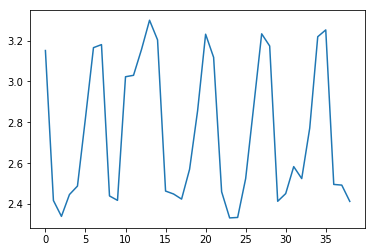

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.907372   
air_0164b9927d20bcc3_2017-04-23              1.417573   
air_0241aa3964b7f861_2017-04-23              2.373109   
air_0328696196e46f18_2017-04-23              2.108393   
air_034a3d5b40d5b1b1_2017-04-23              3.507211   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.735367  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.127092  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.730703  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.234998  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.355106

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l2_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')